In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
import urllib.request
%matplotlib inline

### Data

In [97]:
def read_data(QAP_INSTANCE_URL, verbose = False):
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    if verbose:
        print('Problem size: %d' % n)

    A = np.empty((n, n))
    if n != 50 and n != 60 and n != 80:
        qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    if verbose:
        print('Flow matrix:\n', A)
    
    B = np.empty((n, n))
    if n != 50:
        qap_instance_file.readline()
    
    for i in range(n):
        if n == 30:
            line1 = qap_instance_file.readline()
            line2 = qap_instance_file.readline()
            line = line1 + line2
        else:
            line = qap_instance_file.readline()
        #print(line, i)   
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    if verbose:
        print('Distance matrix:\n', B)
    return A,B,n

In [2]:
def plot_costs(c_min, data, opt, name):
    plt.figure(figsize=(12,4))
    plt.title(f'Costs of {name}\nfound minimum: {c_min:.3f}, optimal:{opt:.3f}', fontdict = {'fontsize' : 20})
    plt.plot(data[:,0], label="Top scores")
    plt.plot(data[:,1], label="Mean scores")
    plt.plot(data[:,2], label="Worst scores")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend(loc='upper right')
    plt.show()

    
def plot_histogram(costs):
    plt.figure(figsize=(12,4))
    plt.xlim(7500, 9200)
    plt.hist(costs, bins=150)
    plt.title("Histogram of costs")
    plt.xlabel("Cost")
    plt.ylabel("Number of results")
    plt.show()

### Mutations

In [3]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [32]:
#function to check all permutations that differs by at most K swaps

def local_search_mutation(p, K = 1):
    
    n = len(p)
    
    # in case we cant permutate (K = 0) or the only permutation is p
    if K == 0 or n == 1:
        return p # p is a numpy array
    
    # base case of recursion 
    if n <= 0:
        return np.array([])
    
    
    permutations = []
    for i in range(0, n):
        tmp = p.copy()
        tmp[0], tmp[i] = tmp[i], tmp[0]
        if i == 0:
            best_perm = np.concatenate((tmp[:1], local_search_mutation(tmp[1:], K)))
        else:
            best_perm = np.concatenate((tmp[:1], local_search_mutation(tmp[1:], K - 1)))
        
        '''#best_perm = tmp[0] + local_search_mutation(tmp[1:], K - 1)
        if i == 0:
            best_perm = [tmp[0]] + local_search_mutation(tmp[1:], K, True)
            #tmp_perm = local_search_mutation(tmp[1:], K, True)
            #print(best_perm, tmp[0], local_search_mutation(tmp[1:], K, True))
        else:
            if first:
                best_perm = [tmp[0]] + local_search_mutation(tmp[1:], K - 2)
                #tmp_perm = local_search_mutation(tmp[1:], K - 2)
                #print(best_perm, tmp[0], local_search_mutation(tmp[1:], K - 2))
            else:
                best_perm = [tmp[0]] + local_search_mutation(tmp[1:], K - 1)
                #tmp_perm = local_search_mutation(tmp[1:], K - 1)
                #print(best_perm, tmp[0], local_search_mutation(tmp[1:], K - 1))'''
                
        permutations.append((best_perm, qap_objective_function(best_perm)))
    
    return min(permutations, key = lambda k: k[1])[0]        

In [39]:
def ls_mutation(p, K = 1):
    n = len(p)
    if K == 0:
        return p
    
    permutations = []
    for i in range(0, n):
        tmp = p.copy()
        tmp[0], tmp[i] = tmp[i], tmp[0]
        
        prmt = ls_mutation(tmp, K - 1)
            
        permutations.append((prmt, qap_objective_function(prmt)))
    
    return min(permutations, key = lambda k: k[1])[0] 
        

In [31]:
def local_iter_search_mutation(p, K = 1):
    curr_score = qap_objective_function(p)
    q = local_search_mutation(p, K)
    mut_score = qap_objective_function(q)
    while(mut_score < curr_score):
        curr_score = mut_score
        p = q
        q = local_search_mutation(p, K)
        mut_score = qap_objective_function(q)
    return p

### SGA algorithm

In [6]:
#Partialy Mapped Crossover
def PMX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()
    p1 = ind1[i:j+1]
    p2 = ind2[i:j+1]
    d_p1 = {p1[k] : p2[k] for k in range(len(p1))}
    d_p2 = {p2[k] : p1[k] for k in range(len(p2))}
    child1 = ind1.copy()
    child2 = ind2.copy()
    
    child1[i:j+1] = p2
    child2[i:j+1] = p1
    
    for k in range(i):
        while child1[k] in d_p2:
            child1[k] = d_p2[child1[k]]
        while child2[k] in d_p1:
            child2[k] = d_p1[child2[k]]
            
    for k in range(j+1, len(ind1)):
        s = 0
        while child1[k] in d_p2:
            child1[k] = d_p2[child1[k]]
            
        while child2[k] in d_p1:
            child2[k] = d_p1[child2[k]]
        
    return child2, child1

In [7]:
#Order Crossover
def OX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    g_start, g_end = a.min(), a.max() # index of group split
    
    groups = []
    if g_start > 0:
        groups.append((0, g_start - 1))
    groups.append((g_start, g_end))
    if g_end < len(ind1) - 1:
        groups.append((g_end + 1, len(ind1) - 1))
        
    # rand index of group we want to inherit
    r = np.random.choice(len(groups))
    i, j = groups[r][0], groups[r][1]
    
    # fragments to inherit
    p1 = ind1[i:j+1]
    p2 = ind2[i:j+1]
    d_p1 = set(p1[k] for k in range(len(p1)))
    d_p2 = set(p2[k] for k in range(len(p2)))
    
    child1 = list(range(len(ind1)))
    child2 = list(range(len(ind2)))
    
    el_for_c1 = []
    el_for_c2 = []
    
    for k in range(j + 1, len(ind1)):
        if ind2[k] not in d_p1:
            el_for_c1.append(ind2[k])
        if ind1[k] not in d_p2:
            el_for_c2.append(ind1[k])
    
    for k in range(0, j + 1):
        if ind2[k] not in d_p1:
            el_for_c1.append(ind2[k])
        if ind1[k] not in d_p2:
            el_for_c2.append(ind1[k])
    
    child1[i:j+1] = p1
    child2[i:j+1] = p2
    
    idx = 0
    
    for k in range(j + 1, len(ind1)):
        child1[k] = el_for_c1[idx]
        child2[k] = el_for_c2[idx]
        idx += 1
    
    for k in range(0, i):
        child1[k] = el_for_c1[idx]
        child2[k] = el_for_c2[idx]
        idx += 1
        
    return child1, child2

In [8]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [16]:
def SGA(F, operator = PMX, number_of_iterations = 250, return_chromosome = False):
    population_size = 500
    chromosome_length = n
    number_of_offspring = population_size
    crossover_probability = 0.95
    mutation_probability = 0.25

    time0 = time.time()

    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))
    
    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = qap_objective_function(current_population[i, :])
    
    costs = np.zeros((number_of_iterations, 3)) # we will keep best, mean and worst cost in i-th iteration
    for t in tqdm(range(number_of_iterations)):
        
        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = operator(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = F(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = qap_objective_function(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]
        
        # recording some statistics
        
        costs[t][0] = objective_values[0]
        costs[t][1] = objective_values.mean()
        costs[t][2] = objective_values[-1]
        
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
    
        #print(best_chromosome)
        #print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))
    #print("s_g_a time:", time.time() - time0)
    if return_chromosome:
        return best_objective_value, costs, best_chromosome
    return best_objective_value, costs

In [72]:
data1 = {}
instances = [(14, 1014),
            (15, 1150),
            ('16a', 1610),
            ('16b', 1240),
            (17, 1732),
            (18, 1930),
            (20, 2570),
            (21, 2438),
            (22, 3596),
            (24, 3488),
            (25, 3744),
            (27, 5234),
            (28, 5166),
            (30, 6124)]
for inst in instances:
    A, B, n = read_data(f'http://anjos.mgi.polymtl.ca/anjos/qaplib/data.d/nug{inst[0]}.dat')

    t0 = time.time()

    data1[inst] = list(SGA(ls_mutation, operator = PMX))
    data1[inst].append(inst[1])
    
    print(inst, time.time() - t0, data1[inst][0])


(14, 1014) 29.277392864227295 1022.0



(15, 1150) 33.2003448009491 1182.0



('16a', 1610) 36.775156021118164 1610.0



('16b', 1240) 35.411988735198975 1278.0



(17, 1732) 39.75342535972595 1806.0



(18, 1930) 46.691752910614014 2030.0



(20, 2570) 53.83899712562561 2634.0



(21, 2438) 59.81464219093323 2554.0



(22, 3596) 64.93856406211853 3650.0



(24, 3488) 77.8609139919281 3664.0



(25, 3744) 82.59075546264648 3930.0



(27, 5234) 90.23948645591736 5480.0



(28, 5166) 89.650554895401 5320.0



(30, 6124) 115.26087474822998 6482.0


In [75]:
data2 = {}
instances = [(12, 578),
            (14, 1014),
            (15, 1150),
            ('16a', 1610),
            ('16b', 1240),
            (17, 1732),
            (18, 1930),
            (20, 2570),
            (21, 2438),
            (22, 3596),
            (24, 3488),
            (25, 3744),
            (27, 5234),
            (28, 5166),
            (30, 6124)]
for inst in instances:
    A, B, n = read_data(f'http://anjos.mgi.polymtl.ca/anjos/qaplib/data.d/nug{inst[0]}.dat')

    t0 = time.time()

    data2[inst] = list(SGA(reverse_sequence_mutation, operator = PMX))
    data2[inst].append(inst[1])
    
    print(inst, time.time() - t0, data2[inst][0])


(12, 578) 7.500705003738403 602.0



(14, 1014) 8.747912883758545 1054.0



(15, 1150) 9.2751784324646 1160.0



('16a', 1610) 9.981832027435303 1634.0



('16b', 1240) 9.919057607650757 1316.0



(17, 1732) 10.367699384689331 1796.0



(18, 1930) 10.222915887832642 1968.0



(20, 2570) 11.80316686630249 2668.0



(21, 2438) 11.808138847351074 2542.0



(22, 3596) 12.050836563110352 3616.0



(24, 3488) 13.225670099258423 3616.0



(25, 3744) 13.922877788543701 3932.0



(27, 5234) 15.227493524551392 5486.0



(28, 5166) 15.25439715385437 5460.0



(30, 6124) 16.24755334854126 6472.0


In [100]:
data3 = {}
instances = [('50a', 4938796),
            ('60a', 7205962),
            ('80a', 13499184)]
for inst in instances:
    A, B, n = read_data(f'http://www.mgi.polymtl.ca/anjos/qaplib/data.d/tai{inst[0]}.dat')

    t0 = time.time()

    data3[inst] = list(SGA(ls_mutation, operator = PMX))
    data3[inst].append(inst[1])
    
    print(inst, time.time() - t0, data3[inst][0])


('50a', 4938796) 313.7300989627838 5307924.0



('60a', 7205962) 457.60763025283813 7642530.0



('80a', 13499184) 720.0007581710815 14476102.0


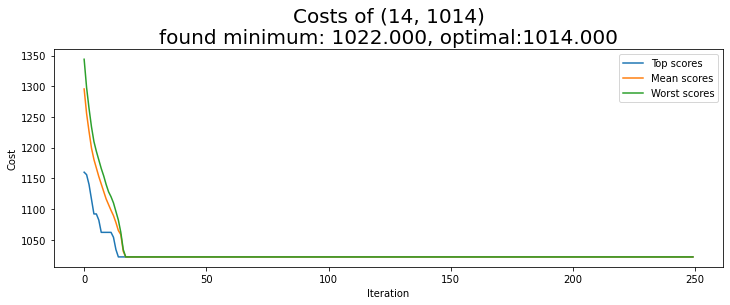

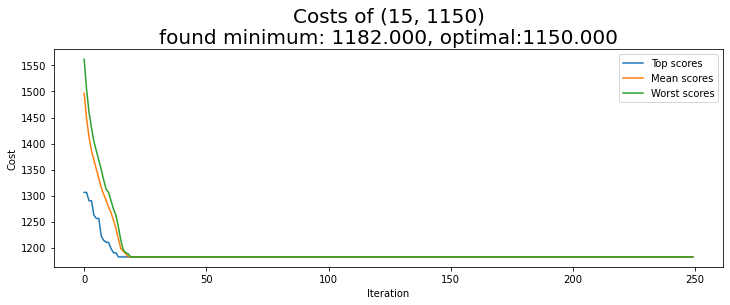

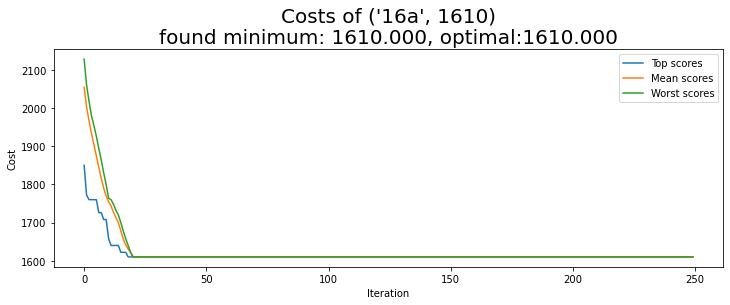

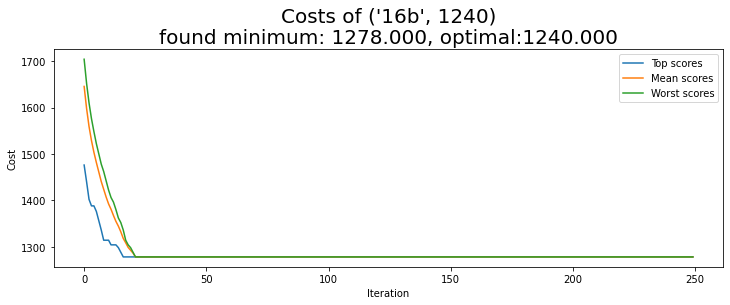

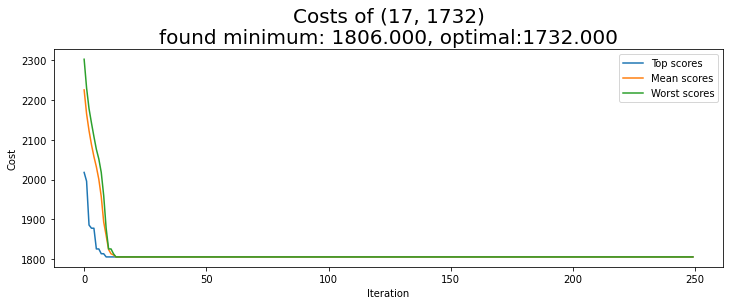

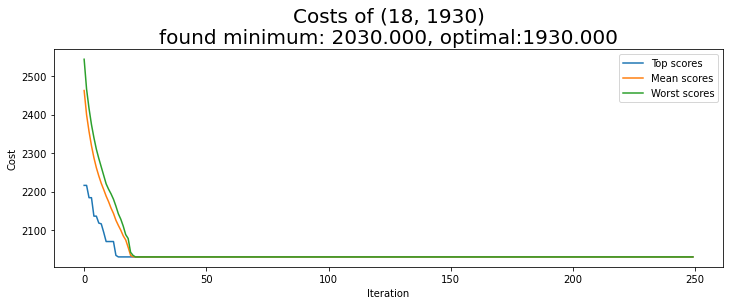

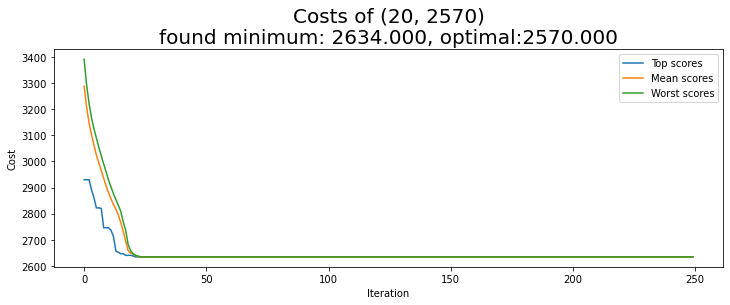

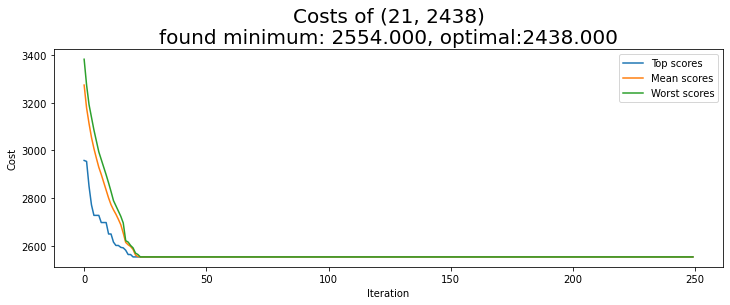

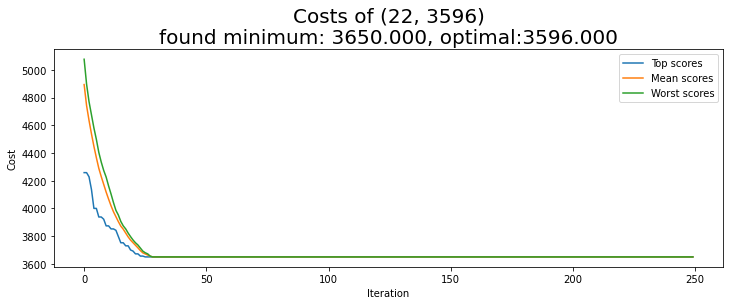

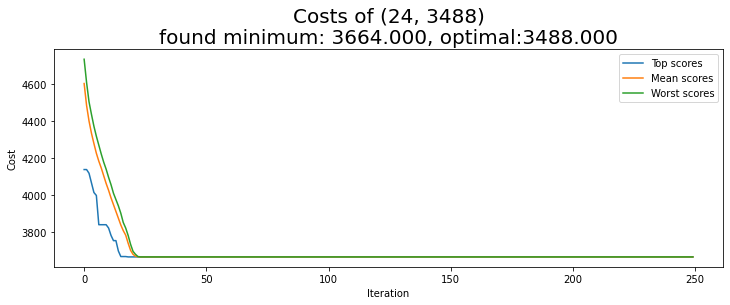

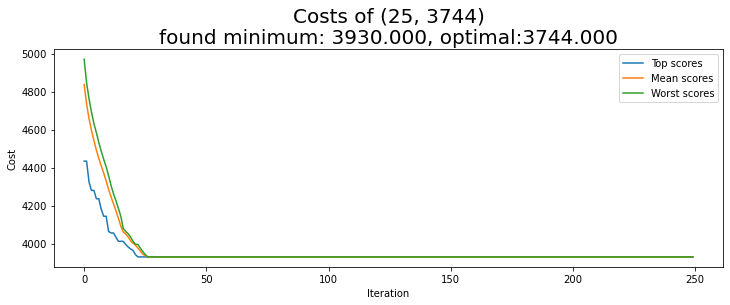

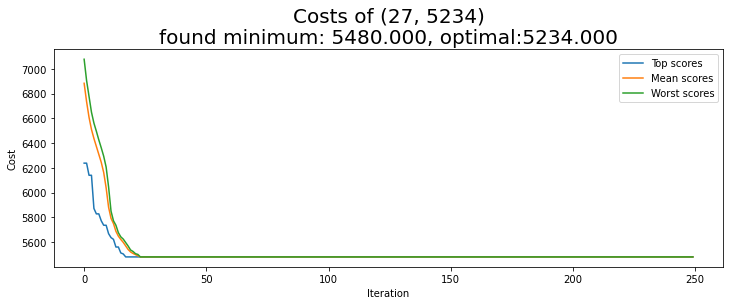

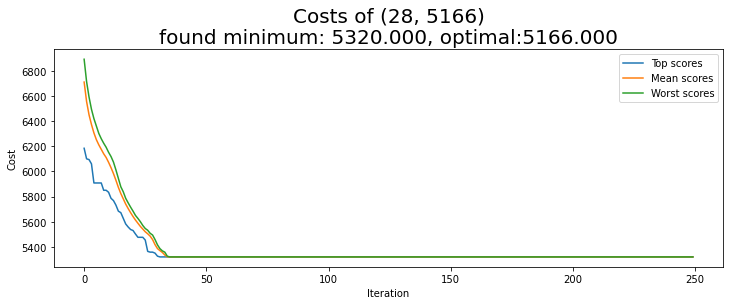

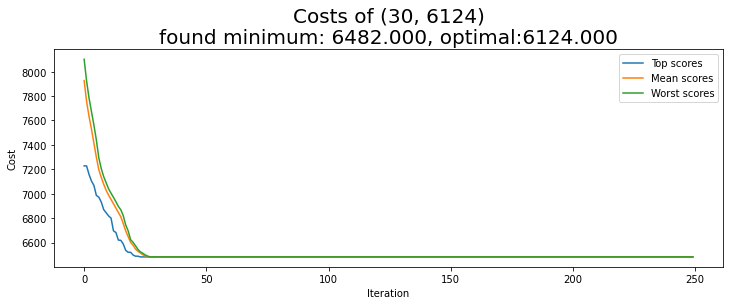

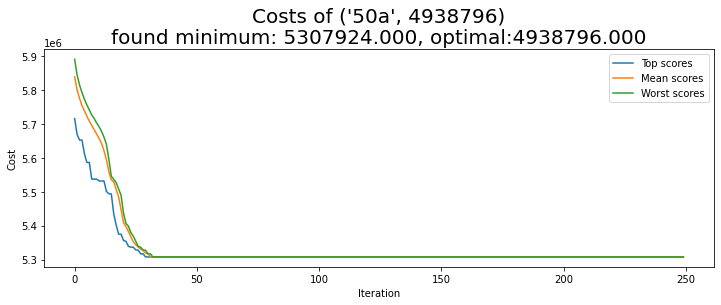

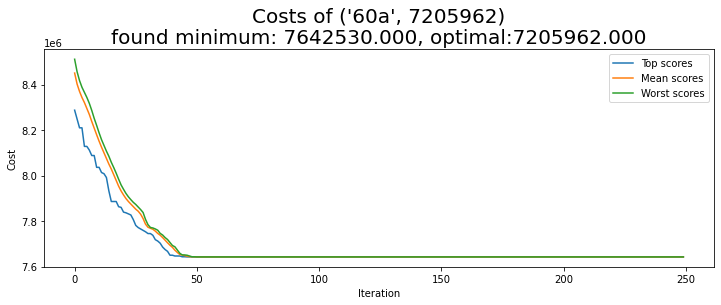

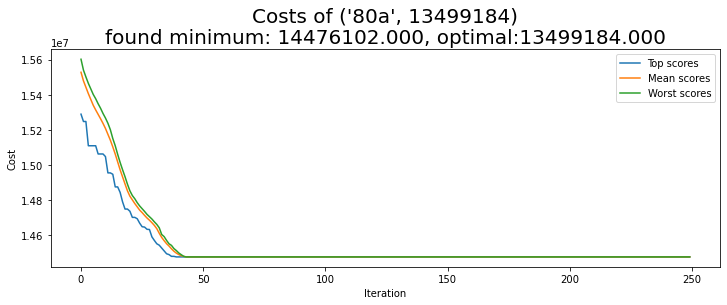

In [101]:
for k in data1:
    plot_costs(data1[k][0], data1[k][1], data1[k][2], k)

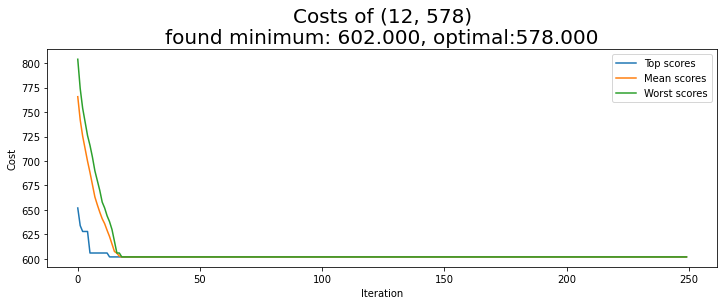

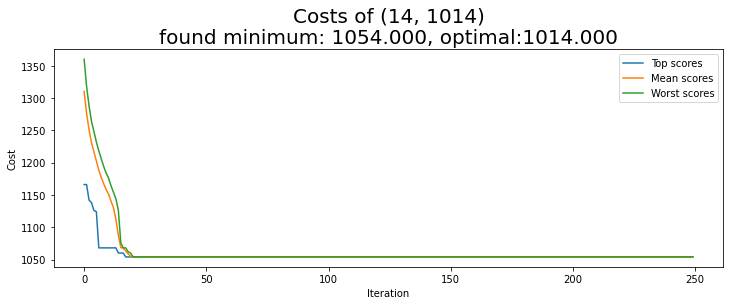

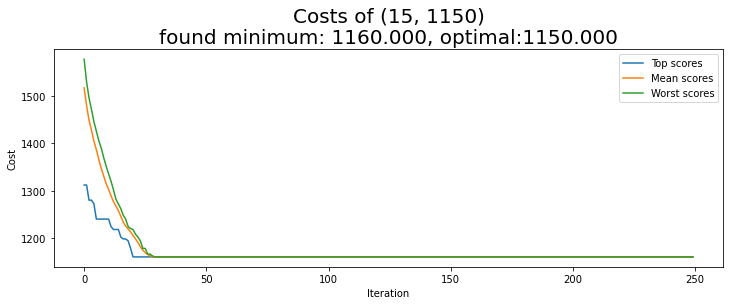

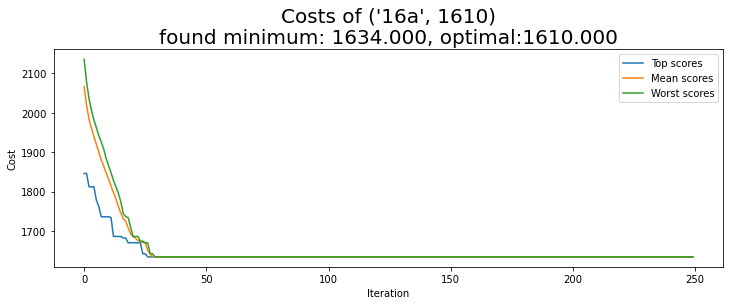

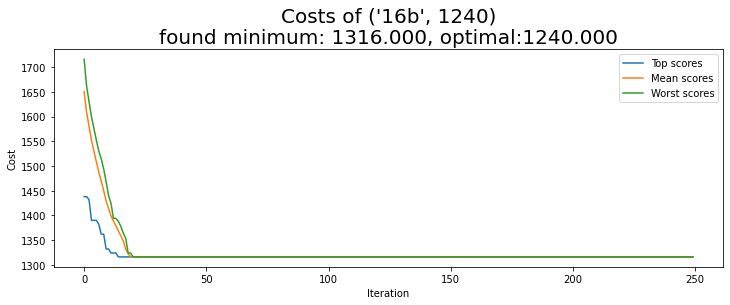

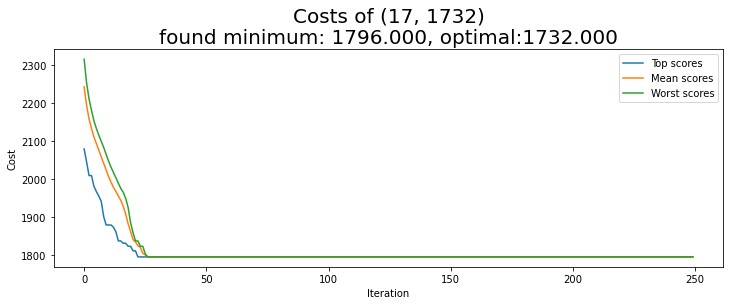

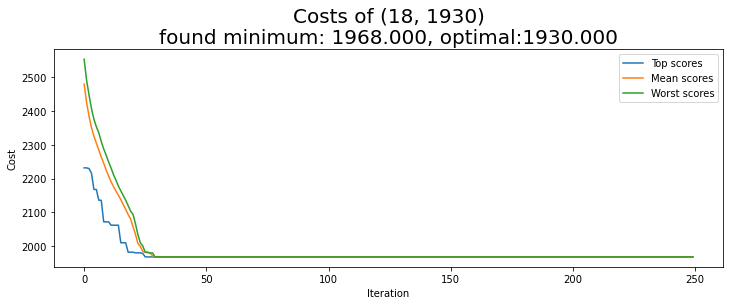

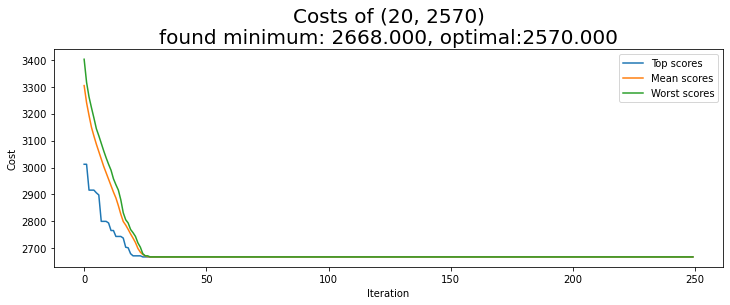

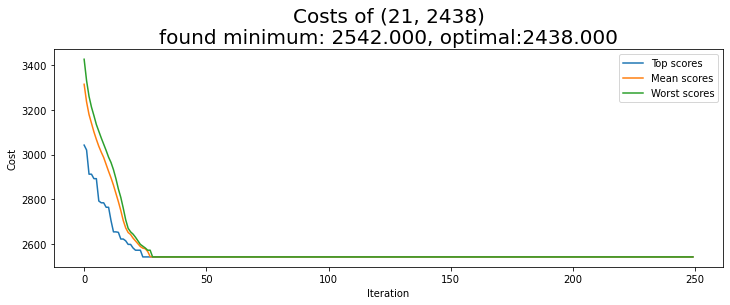

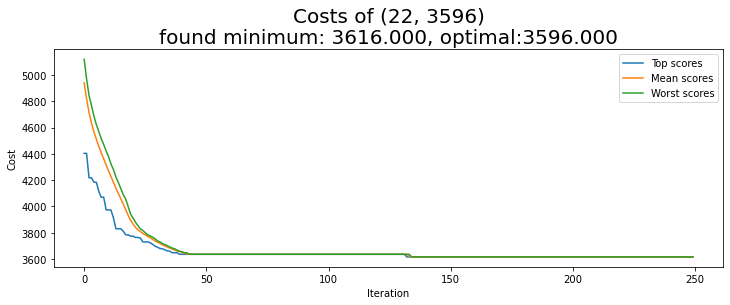

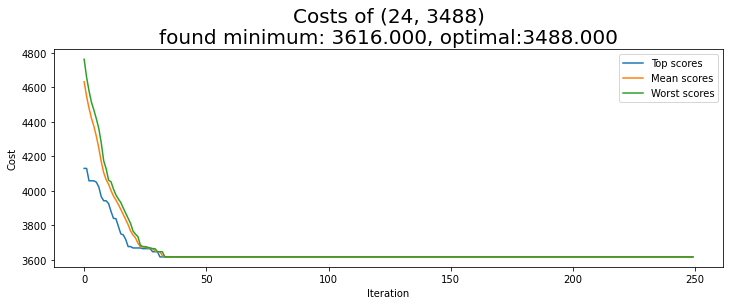

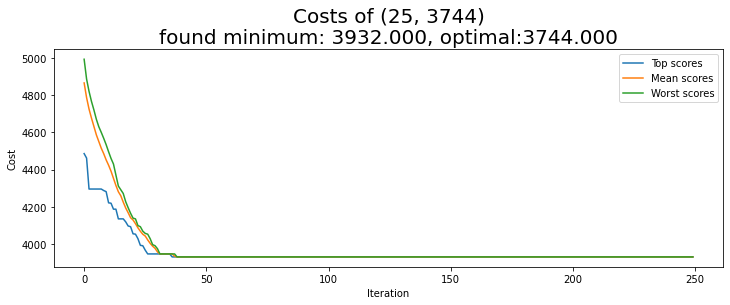

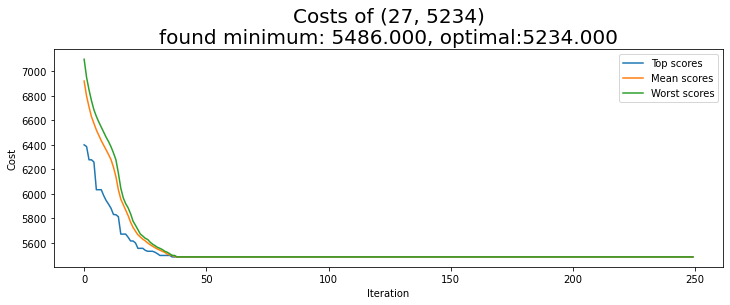

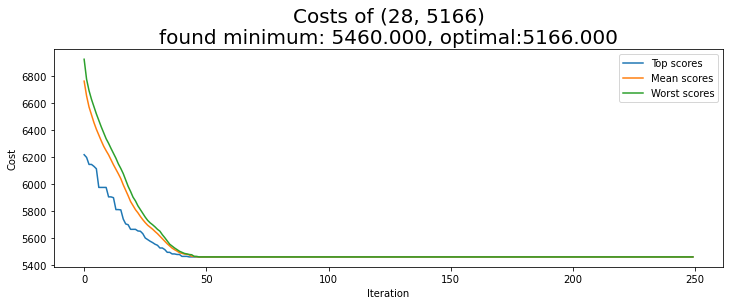

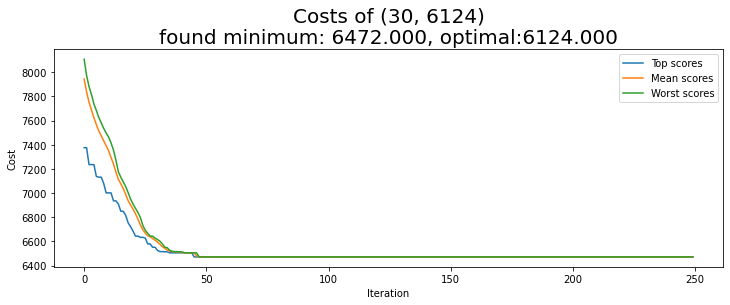

In [102]:
for k in data2:
    plot_costs(data2[k][0], data2[k][1], data2[k][2], k)

In [103]:
for k in data3:
    plot_costs(data3[k][0], data3[k][1], data3[k][2], k)